# Machine Learning Analysis
The goal is to examine whether a country’s dominant political ideology – categorized as left, center, or right – can be predicted from its economic indicators. We also explore how economic metrics (e.g. growth, trade, military spending)
## 1. Importing Libraries
Let's start by importing all the libraries we'll need for our analysis:

In [19]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.decomposition import PCA



## 2. Loading Our Data
We load the datasets for global economy indicators, political ideologies, and military spending:

In [2]:
economy = pd.read_csv('global_economy_indicators.csv')
ideology = pd.read_csv('global_leader_ideologies.csv')
military = pd.read_csv('military_spending_dataset.csv')

In [3]:
print(economy.columns)
print(ideology.columns)
print(military.columns)


Index([' CountryID ', ' Country ', ' Year ', ' AMA exchange rate ',
       ' IMF based exchange rate ', ' Population ', ' Currency ',
       ' Per capita GNI ',
       ' Agriculture, hunting, forestry, fishing (ISIC A-B) ',
       ' Changes in inventories ', ' Construction (ISIC F) ',
       ' Exports of goods and services ', ' Final consumption expenditure ',
       ' General government final consumption expenditure ',
       ' Gross capital formation ',
       ' Gross fixed capital formation (including Acquisitions less disposals of valuables) ',
       ' Household consumption expenditure (including Non-profit institutions serving households) ',
       ' Imports of goods and services ', ' Manufacturing (ISIC D) ',
       ' Mining, Manufacturing, Utilities (ISIC C-E) ',
       ' Other Activities (ISIC J-P) ', ' Total Value Added ',
       ' Transport, storage and communication (ISIC I) ',
       ' Wholesale, retail trade, restaurants and hotels (ISIC G-H) ',
       ' Gross National In

## 3. Cleaning and Preparing Data
First, we'll make sure all country names match across datasets by standardizing them:

In [4]:
def standardize_country_names(df):
    df.columns = df.columns.str.lower().str.strip()

    if 'country' in df.columns:
        df['country'] = df['country'].str.strip().str.lower()
    elif 'country_name' in df.columns:
        df.rename(columns={'country_name': 'country'}, inplace=True)
        df['country'] = df['country'].str.strip().str.lower()
    elif 'country name' in df.columns:
        df.rename(columns={'country name': 'country'}, inplace=True)
        df['country'] = df['country'].str.strip().str.lower()
    elif 'nation' in df.columns:
        df.rename(columns={'nation': 'country'}, inplace=True)
        df['country'] = df['country'].str.strip().str.lower()
    else:
        raise KeyError("No country-related column found. Available columns: " + ', '.join(df.columns))
    return df



In [5]:
economy = standardize_country_names(economy)
ideology = standardize_country_names(ideology)
military = standardize_country_names(military)


Reshape military from wide to long format:

In [6]:
military_long = pd.melt(
    military,
    id_vars=['country', 'indicator name', 'indicator code', 'country code'],
    var_name='year',
    value_name='military_spending'
)

military_long['year'] = pd.to_numeric(military_long['year'], errors='coerce')
military_long.dropna(subset=['year'], inplace=True)


Now, let's merge our data:

In [7]:
merged = pd.merge(economy, ideology, on=['country', 'year'], how='inner')
merged = pd.merge(merged, military_long[['country', 'year', 'military_spending']], on=['country', 'year'], how='left')


We'll handle missing values by filling them with median values:


In [8]:
merged.fillna(merged.median(numeric_only=True), inplace=True)


We Log-transform skewed continuous variables to normalize distributions:


In [9]:
merged.rename(columns={
    'gross domestic product (gdp)': 'gdp',
    'gross national income(gni) in usd': 'gni_per_capita'
}, inplace=True)

for col in ['gdp', 'gni_per_capita', 'military_spending']:
    merged[f'log_{col}'] = np.log1p(merged[col])

And encode categorical variables for modeling:


In [10]:
merged['ideology_encoded'] = LabelEncoder().fit_transform(merged['leader_ideology'])


## 4. Exploratory Data Analysis
Here's a quick look at summary statistics:

In [11]:
print(merged.describe())


         countryid         year  ama exchange rate  imf based exchange rate  \
count  7179.000000  7179.000000       7.179000e+03             7.179000e+03   
mean    416.902075  1996.393787       2.904437e+02             2.879187e+02   
std     248.547960    14.489424       1.478001e+03             1.477178e+03   
min       4.000000  1970.000000       1.990000e-12             8.880000e-14   
25%     204.000000  1984.000000       9.998750e-01             9.708387e-01   
50%     422.000000  1997.000000       4.402778e+00             4.144753e+00   
75%     620.000000  2009.000000       7.264702e+01             6.898615e+01   
max     894.000000  2020.000000       3.155891e+04             3.155891e+04   

         population  per capita gni  \
count  7.179000e+03     7179.000000   
mean   3.357497e+07     7622.343502   
std    1.323453e+08    13286.029605   
min    6.218100e+04       53.000000   
25%    2.323002e+06      665.500000   
50%    6.840457e+06     1981.000000   
75%    1.836771

Visualizing correlations helps us see how variables relate:

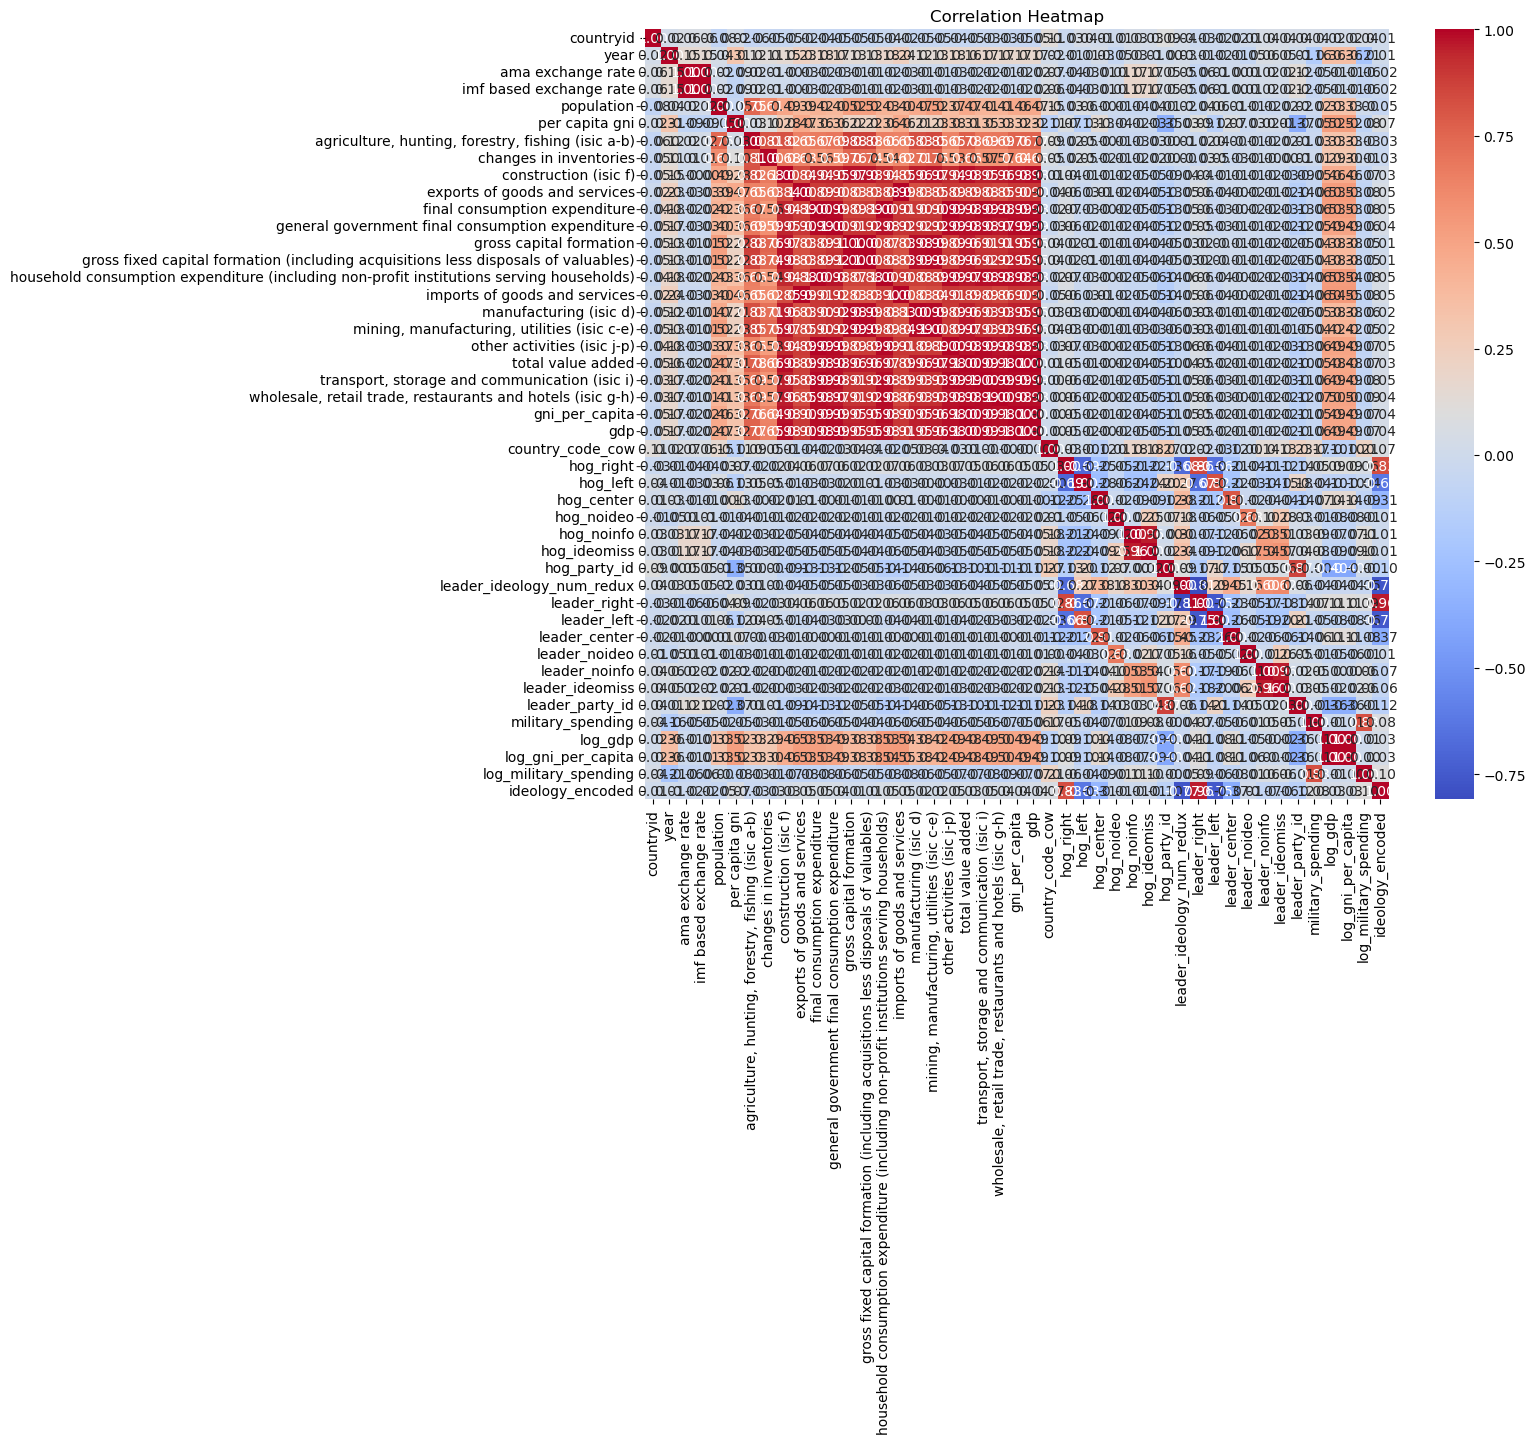

In [12]:
plt.figure(figsize=(12,10))
sns.heatmap(merged.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


Checking for clusters among countries using PCA:


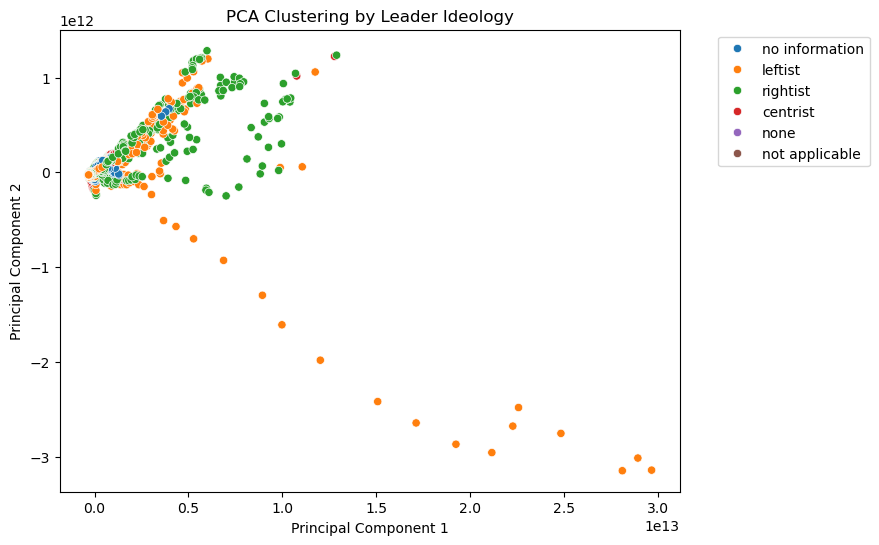

In [20]:

pca = PCA(n_components=2)
numerical_cols = merged.select_dtypes(include=np.number).dropna(axis=1)
pca_result = pca.fit_transform(numerical_cols)

plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=merged['leader_ideology'])
plt.title('PCA Clustering by Leader Ideology')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## 5. Building Predictive Models
We'll select features and target variable to predict political ideology:

In [21]:
features = ['log_gdp', 'log_gni_per_capita', 'log_military_spending']
features = [f for f in features if f in merged.columns]  # check column existence

X = merged[features]
y = merged['ideology_encoded']



Let's scale our features:

In [22]:
print(merged.columns)


Index(['countryid', 'country', 'year', 'ama exchange rate',
       'imf based exchange rate', 'population', 'currency', 'per capita gni',
       'agriculture, hunting, forestry, fishing (isic a-b)',
       'changes in inventories', 'construction (isic f)',
       'exports of goods and services', 'final consumption expenditure',
       'general government final consumption expenditure',
       'gross capital formation',
       'gross fixed capital formation (including acquisitions less disposals of valuables)',
       'household consumption expenditure (including non-profit institutions serving households)',
       'imports of goods and services', 'manufacturing (isic d)',
       'mining, manufacturing, utilities (isic c-e)',
       'other activities (isic j-p)', 'total value added',
       'transport, storage and communication (isic i)',
       'wholesale, retail trade, restaurants and hotels (isic g-h)',
       'gni_per_capita', 'gdp', 'country_code_cow', 'hog', 'hog_ideology',
      

In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Now, split our data:

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


And fit some predictive models:


- **Logistic Regression**:

In [25]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
print('Logistic Regression Accuracy:', accuracy_score(y_test, log_reg.predict(X_test)))

Logistic Regression Accuracy: 0.4832869080779944


- **Support Vector Machine (SVM)**:

In [26]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)
print('SVM Accuracy:', accuracy_score(y_test, svm.predict(X_test)))

SVM Accuracy: 0.4881615598885794


- **Neural Network**:

In [27]:
mlp = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=500)
mlp.fit(X_train, y_train)
print('Neural Network Accuracy:', accuracy_score(y_test, mlp.predict(X_test)))

Neural Network Accuracy: 0.532033426183844


## 6. Model Evaluation and Comparison
We'll use cross-validation to check our models:

In [28]:
models = {'Logistic Regression': log_reg, 'SVM': svm, 'Neural Network': mlp}
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=5)
    print(f"{name} Cross-validation Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})")

Logistic Regression Cross-validation Accuracy: 0.48 (+/- 0.07)
SVM Cross-validation Accuracy: 0.47 (+/- 0.04)
Neural Network Cross-validation Accuracy: 0.46 (+/- 0.04)


Feature importance tells us what features matter most:

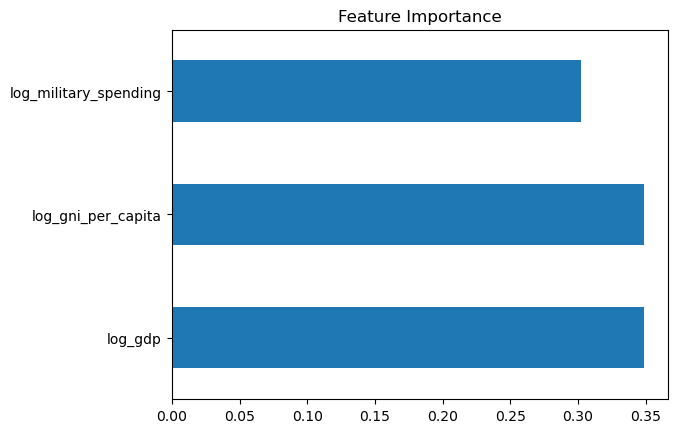

In [29]:
rf = RandomForestClassifier().fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=features)
importances.plot(kind='barh', title='Feature Importance')
plt.show()

## 7. Reflection on Generative AI
We used generative AI to help write code, clarify methods, and interpret results. AI made generating initial code and explaining results quicker. However, we carefully checked and revised AI-generated content to ensure accuracy and relevance.


## 8. Conclusions
From our analysis, we've seen that economic indicators can help predict political ideologies, but not perfectly. Features like GDP, income levels, and military spending were important predictors. This analysis gives useful insights into how economics might influence politics globally.
